# Lab 05 – Iris Classification (1)

# 1. Introduction
In this practical, we will apply a **classification algorithm** to the **Iris dataset**.

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/iris). Due to its small size and popularity, it is also included in many machine learning libraries such as [scikit-learn](https://scikit-learn.org/stable/index.html) (`sklearn`).

# 2. Objective
1. Load and explore the Iris dataset, understanding its features and target classes.
2. Split the dataset into training and testing subsets to support model evaluation.
3. Explore Different Ways to Split Data for Cross-Validation
4. Train and tune a k-Nearest Neighbors (k-NN) classifier using cross-validation to select the best parameters.

## Task 1: Import the Iris data from sklearn. 
Read the documenation that describes the data, what the attributes are, and what the classification task is.

In [13]:
# -------------------------------------------------------
# Iris Dataset: Data Inspection
# -------------------------------------------------------

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Load the Iris dataset from scikit-learn
iris = datasets.load_iris()

# Inspect the available keys in the dataset object
# These keys provide access to data, target labels, metadata, etc.
print("Available keys in the Iris dataset:", iris.keys())

# View the dataset description to understand:
# - Feature names and units
# - Target class labels
# - Dataset size and format
# - Source information
print("\nDataset Description:\n")
print(iris['DESCR'])

Available keys in the Iris dataset: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Dataset Description:

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal l

In [14]:
# -------------------------------------------------------
# Extract features (X) and target labels (y) from the Iris dataset
# -------------------------------------------------------

# X: Data matrix containing the feature values for each instance
#    Shape: (n_samples, n_features)
#    In the Iris dataset:
#       - n_samples = 150
#       - n_features = 4 (sepal length, sepal width, petal length, petal width)
X = iris['data']

# y: Target vector containing the class label for each instance
#    Shape: (n_samples,)
#    Classes: 0 = setosa, 1 = versicolor, 2 = virginica
y = iris['target']

# Optional: Check shapes to confirm dimensions
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (150, 4)
y shape: (150,)


## Task 2: Split the Data into Training and Testing Sets
Divide the dataset into two subsets:

- **Training set**: 75% of the data, used to fit the model.
- **Testing set**: 25% of the data, used to evaluate model performance.

Ensure that the **class distribution** is preserved in both subsets (stratified sampling) and that the split is **reproducible** by setting a random seed.

In [48]:
# -------------------------------------------------------
# Split the data into training and testing subsets
# -------------------------------------------------------

from sklearn.model_selection import train_test_split

# Split the dataset:
# - 75% for training
# - 25% for testing
# - Stratify by 'y' to preserve class distribution in both sets
# - Set random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    
    #Your Answer
    test_size=?,           # 25% test data
    #Your Answer
    
    stratify=y,            # keep class proportions consistent
    random_state=42        # Why random_state=42
)

# Check resulting shapes
print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape:  X={X_test.shape}, y={y_test.shape}")

Training set shape: X=(112, 4), y=(112,)
Testing set shape:  X=(38, 4), y=(38,)


## Task 3: Explore Different Ways to Split Data for Cross-Validation

`scikit-learn` provides several cross-validation (CV) strategies, each with different sampling behaviour:

- **`ShuffleSplit`** — Creates random train/test partitions for each split (repeated random holdout).  
- **`KFold`** — Divides data into *k* sequential folds without considering class labels (unless `shuffle=True`).  
- **`StratifiedKFold`** — Divides data into *k* folds while preserving the proportion of each class in every fold (recommended for classification).

In this exercise, we will generate **10 splits** using each method and **visualise** the train/test allocation patterns.

> **Note:** In `ShuffleSplit`, “10 splits” means 10 independent random partitions — they are not disjoint folds.

In [49]:
# -------------------------------------------------------
# Cross-validation splitters for the Iris dataset
# -------------------------------------------------------
from sklearn.model_selection import StratifiedKFold, KFold, ShuffleSplit

# 1. ShuffleSplit — Random sampling
#    Each split randomly selects test samples without preserving order.
#    Here, test_size=15 means 15 samples will be used for testing in each split.
ss = ShuffleSplit(
    n_splits=10,      # number of random splits
    test_size=15,     # absolute number of test samples per split
    random_state=4    # reproducibility
)

# 2. KFold — Ordered, non-stratified k-fold splitting
#    Splits the dataset into k contiguous folds (no shuffling by default).
kf = KFold(
    n_splits=10       # number of folds
    # shuffle=False by default
)

# 3. StratifiedKFold — Stratified k-fold splitting
#    Ensures that each fold has approximately the same class proportions as the full dataset.
skf = StratifiedKFold(
    n_splits=10       # number of folds
    # shuffle=False by default; set shuffle=True for randomised stratified folds
)

In [50]:
# -------------------------------------------------------
# Helper function to visualise cross-validation splits
# Adapted from the scikit-learn documentation:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
# -------------------------------------------------------

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Colour maps
cmap_data = plt.cm.Paired      # for data labels
cmap_cv = plt.cm.coolwarm      # for train/test split indication

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """
    Visualise the train/test indices produced by a cross-validation splitter.

    Parameters
    ----------
    cv : cross-validation splitter object
        An instance of a scikit-learn CV splitter (e.g., KFold, StratifiedKFold).

    X : array-like, shape (n_samples, n_features)
        Feature matrix.

    y : array-like, shape (n_samples,)
        Target labels.

    group : array-like, shape (n_samples,)
        Group labels for group-based cross-validation, or dummy array if unused.

    ax : matplotlib Axes
        The axes object on which to plot.

    n_splits : int
        Number of CV splits.

    lw : int, optional (default=10)
        Line width for plotting markers.
    """

    # Iterate over each split and plot the train/test indices
    for ii, (train_idx, test_idx) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Initialise with NaN for all samples
        indices = np.array([np.nan] * len(X))
        
        # Mark test indices with 1, train indices with 0
        indices[test_idx] = 1
        indices[train_idx] = 0

        # Plot train/test assignments for this split
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker='_',
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2
        )

    # Plot class labels row
    ax.scatter(
        range(len(X)),
        [ii + 1.5] * len(X),
        c=y,
        marker='_',
        lw=lw,
        cmap=cmap_data
    )

    # Plot group labels row
    ax.scatter(
        range(len(X)),
        [ii + 2.5] * len(X),
        c=group,
        marker='_',
        lw=lw,
        cmap=cmap_data
    )

    # Configure axis labels and ticks
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel='Sample index',
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2]
    )
    ax.set_title(f"{type(cv).__name__}", fontsize=15)

    return ax

/tmp/ipykernel_48009/2752710405.py:75: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/tmp/ipykernel_48009/2752710405.py:75: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/tmp/ipykernel_48009/2752710405.py:75: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


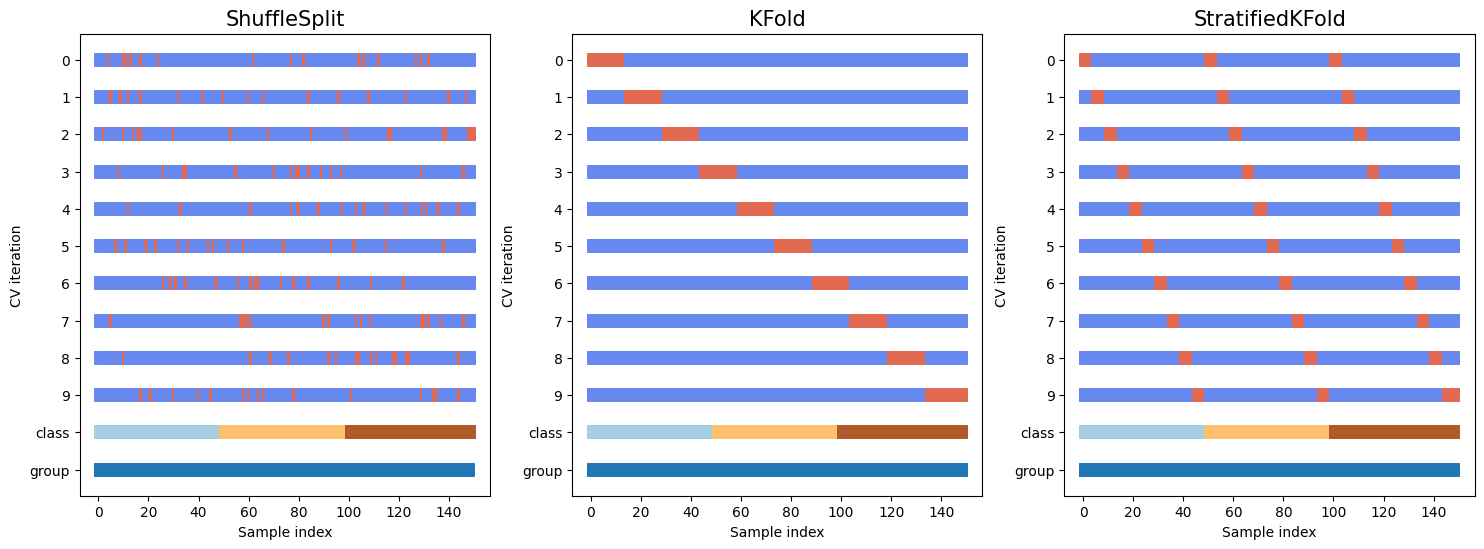

In [51]:
# -------------------------------------------------------
# Visualise different cross-validation splitting strategies
# -------------------------------------------------------

# Set up a figure with three subplots (side-by-side)
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# 1. Visualise ShuffleSplit
plot_cv_indices(
    cv=ss,           # ShuffleSplit instance
    X=X,
    y=y,
    group=None,      # no grouping in this example
    ax=ax[0],
    n_splits=10
)

# 2. Visualise KFold
plot_cv_indices(
    cv=kf,           # KFold instance
    X=X,
    y=y,
    group=None,
    ax=ax[1],
    n_splits=10
)

# 3. Visualise StratifiedKFold
plot_cv_indices(
    cv=skf,          # StratifiedKFold instance
    X=X,
    y=y,
    group=None,
    ax=ax[2],
    n_splits=10
)

# Display the figure
plt.show()

### Interpreting the Cross-Validation Split Visualisation

- **Horizontal axis (sample index):** Shows the 150 instances in the dataset, ordered by their index.
- **Vertical axis (rows):** Each row corresponds to one cross-validation iteration (split). The last two rows show:
  - **Class labels** for each instance (colour-coded).
  - **Group labels** (not used here; you can ignore this row).

- **Colour meaning (per split row):**
  - **Blue** = training samples
  - **Orange** = test samples  
  Notice how the train–test pattern differs across the three methods:
  - **ShuffleSplit:** random 25% test selection each time (rows look scattered).
  - **KFold:** contiguous, non-stratified folds (blocks from left to right).
  - **StratifiedKFold:** folds preserve class proportions in every split.

- **Class balance and ordering:**
  - The Iris dataset has **three classes with equal counts** (50 each).
  - Because the data are **sorted by class** (0, then 1, then 2), the class-label row appears as **three equal-length colour blocks**.
  
- **Note on the “group” row:**  
  It’s included for completeness of the plotting function but **not used** in this example.


From the above figre, decide which splitting algorithm is likely to give us the best results.

## Task 4 – k-NN Classifier with Cross-Validation

In this task, we apply a **k-Nearest Neighbors (k-NN)** classifier to the Iris dataset and use **10-fold Stratified Cross-Validation** to find the best number of neighbours (`k`).

**Steps:**
1. Load the Iris dataset and split into training and test sets.
2. Build a pipeline with:
   - `StandardScaler` for z-score feature scaling.
   - `KNeighborsClassifier` for classification.
3. Evaluate `k = 1, 3, 7, 11, 17, 21` using cross-validation on the training set.
4. Select the `k` with the highest mean CV accuracy as the **champion model**.
5. Retrain the champion on the full training set and evaluate on the test set.
6. Display the classification report and confusion matrix.
7. Plot confusion matrices for all `k` values for comparison.

X shape: (150, 4) | y shape: (150,) | classes: ['setosa', 'versicolor', 'virginica']

Cross-validation accuracy by k (training set):
 k  mean_cv_acc  std_cv_acc
17     0.973485    0.040550
 3     0.955303    0.060459
11     0.955303    0.060459
 7     0.955303    0.060459
21     0.946212    0.072383
 1     0.937121    0.070747


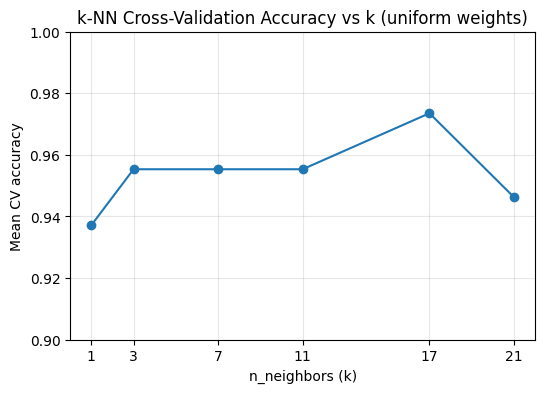

In [52]:
# -------------------------------------------------------
# k-NN model selection with scaling + cross-validation
# -------------------------------------------------------

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay
)

# Load data
iris = datasets.load_iris()
X = # Your Code
y = # Your Code
target_names = iris.get("target_names", np.array(["class 0","class 1","class 2"]))
print(f"X shape: {X.shape} | y shape: {y.shape} | classes: {target_names.tolist()}")

# Stratified train/test split (hold-out set for final evaluation)
X_train, X_test, y_train, y_test = # Your code

# The following code specifies a stratified 10-fold cross-validation strategy with shuffling enabled:

# Your code
skf = 
# Your code

k_values = [1, 3, 7, 11, 17, 21] # trial values for k

# Helper: build a pipeline = z-score scaling -> k-NN
def make_knn_pipeline(k, weights="uniform"):
    return Pipeline([
        ("scaler", StandardScaler()),                 # z-score scaling: (x-μ)/σ
        ("knn", KNeighborsClassifier(n_neighbors=k, weights=weights))
    ])

# Cross-validate each k on the TRAINING set only
cv_records = []
for k in k_values:
    pipe = make_knn_pipeline(k=k, weights="uniform")
    scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring="accuracy", n_jobs=-1)
    cv_records.append({"k": k, "mean_cv_acc": scores.mean(), "std_cv_acc": scores.std()})

cv_df = pd.DataFrame(cv_records).sort_values("mean_cv_acc", ascending=False).reset_index(drop=True)
print("\nCross-validation accuracy by k (training set):")
print(cv_df.to_string(index=False))

# 5) Plot mean CV accuracy vs k (accuracy only, no error bars)
df_plot = cv_df.sort_values("k")
plt.figure(figsize=(6, 4))
plt.plot(df_plot["k"], df_plot["mean_cv_acc"], marker="o")
plt.xlabel("n_neighbors (k)")
plt.ylabel("Mean CV accuracy")
plt.title("k-NN Cross-Validation Accuracy vs k (uniform weights)")
plt.xticks(df_plot["k"])
plt.ylim(0.9, 1.0)  # optional zoom for clarity
plt.grid(True, alpha=0.3)
plt.show()


Best k by CV: 17
Test accuracy (k=17): 0.974

Classification report (test set):
              precision    recall  f1-score   support

      setosa      1.000     1.000     1.000        12
  versicolor      0.929     1.000     0.963        13
   virginica      1.000     0.923     0.960        13

    accuracy                          0.974        38
   macro avg      0.976     0.974     0.974        38
weighted avg      0.976     0.974     0.974        38



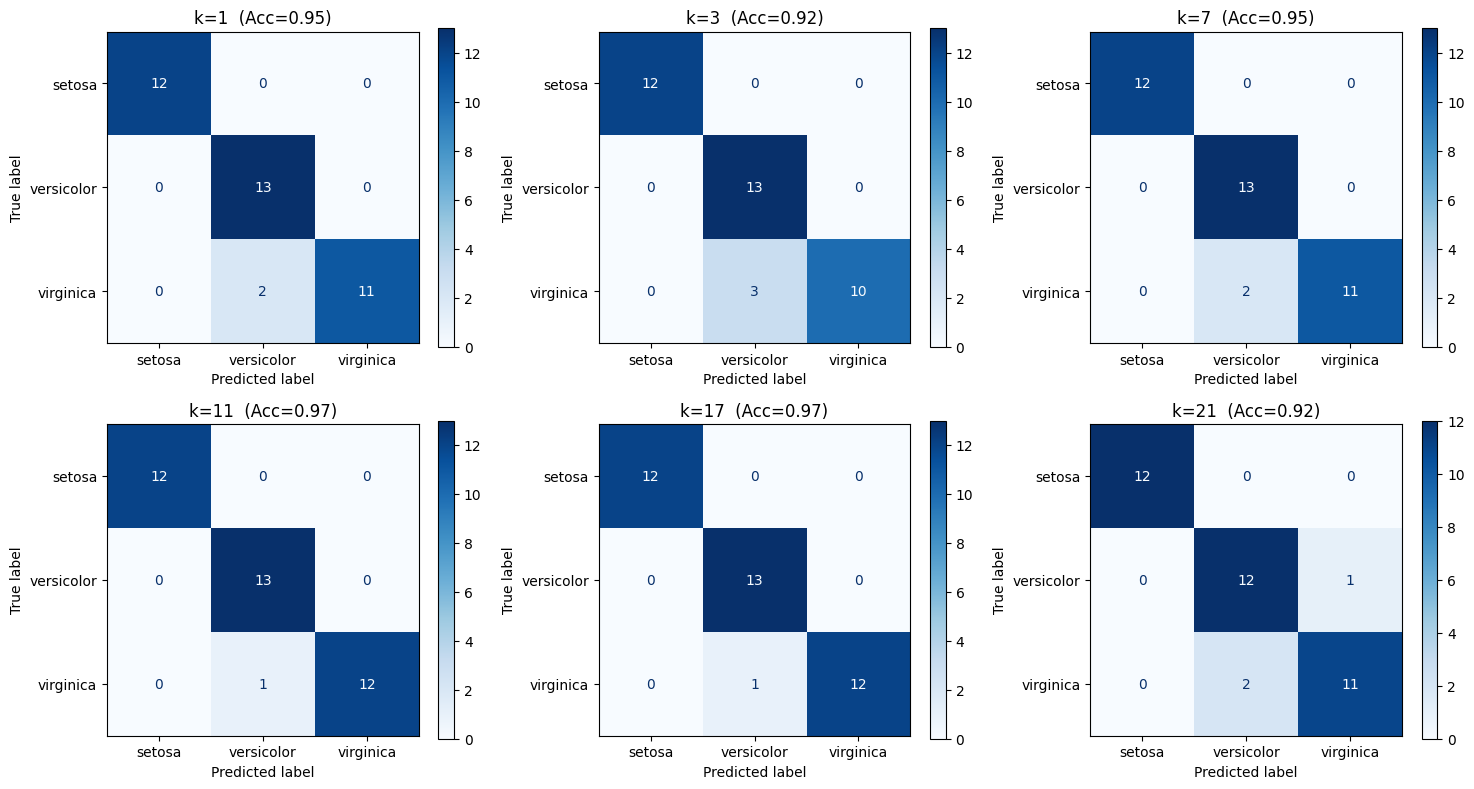

In [53]:
# Select best k, retrain on full TRAIN set, evaluate on TEST set
best_k = int(cv_df.loc[0, "k"])
print(f"\nBest k by CV: {best_k}")

best_pipe = make_knn_pipeline(k=best_k, weights="uniform")
best_pipe.fit(X_train, y_train)

y_pred_best = best_pipe.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_best)
print(f"Test accuracy (k={best_k}): {test_acc:.3f}")

print("\nClassification report (test set):")
print(classification_report(y_test, y_pred_best, target_names=target_names, digits=3))

# Confusion matrices for ALL k values (trained on TRAIN, evaluated on TEST)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
for idx, k in enumerate(k_values):
    r, c = divmod(idx, cols)
    pipe = make_knn_pipeline(k=k, weights="uniform")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=target_names,
        cmap="Blues",
        values_format="d",
        ax=axes[r, c]
    )
    axes[r, c].set_title(f"k={k}  (Acc={acc:.2f})")

plt.tight_layout()
plt.show()